# ML using ds with NAs and binned columns removed

### Load data, libraries

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("clean_speeddating_with_na_no_bins2.csv", low_memory=False)

## Feature selection using K-Best

### First preprocess

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

##first have to preprocess

#make an encoder for all the categorical columns
encoder = OneHotEncoder(handle_unknown='infrequent_if_exist')
categorical_cols = ["gender", "race", "race_o", "field"]

#standard scale all numeric columns since some are on scale of 0-100 and some from 1-10 and some are binary (like same_race)
std_scaler = StandardScaler()
all_cols = df.columns.tolist()
numeric_cols = [col for col in all_cols if col not in categorical_cols]
numeric_cols.remove('match')

#now use a column transformer to do both pre processors on their separate columns
transformer = ColumnTransformer(
        [('categories', encoder, categorical_cols),
        ('numeric', std_scaler, numeric_cols)],
        remainder='drop', verbose_feature_names_out=False)

### Split ds

In [6]:
from sklearn.model_selection import train_test_split

df_no_nan = df.dropna() #drop nas

X2 = df_no_nan.loc[:, df_no_nan.columns != 'match']
y2 = df_no_nan['match']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=0)

### K-Best

<Axes: >

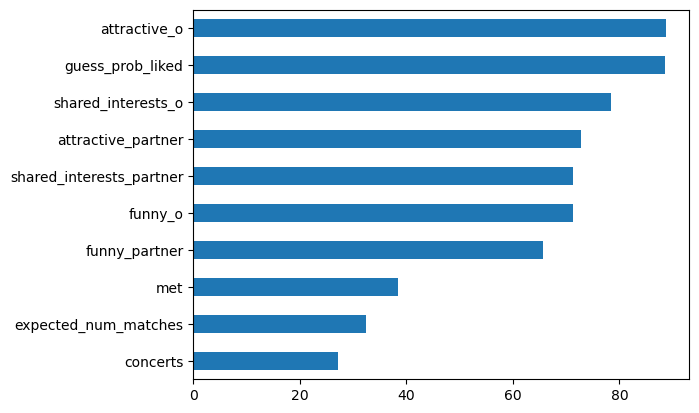

In [7]:
transformer.fit(X_train2, y_train2)

feature_selector = SelectKBest(k=10)

X_train_trans2 = transformer.transform(X_train2)

X_train_trans_df2 = pd.DataFrame(X_train_trans2, columns = transformer.get_feature_names_out(),
                                index = X_train2.index)

feature_selector.fit(X_train_trans_df2, y_train2)

X_train_trans_df2.columns[feature_selector.get_support()]

top_feature_importance_scores = feature_selector.scores_[feature_selector.get_support()]

top_feature_importance_names = X_train_trans_df2.columns[feature_selector.get_support()]

pd.Series(top_feature_importance_scores, index=top_feature_importance_names).sort_values(ascending=True).plot(kind='barh')

## Move forward only using top 10 features

In [8]:
top10 = ['attractive_o', 'guess_prob_liked', 'shared_interests_o', 'attractive_partner', 'shared_interests_partner', 'funny_o', 'funny_partner', 'met', 'expected_num_matches', 'concerts']

### Re-split new data

In [9]:
#resplit the data using only the top features. still had to use the non-nan data for the models below
X_top10 = df_no_nan[top10]
y_top10 = df_no_nan['match']

X_train_top10, X_test_top10, y_train_top10, y_test_top10 = train_test_split(X_top10, y_top10, random_state=0)

## Try ensemble to see which models work best

In [10]:
from sklearn.naive_bayes import BernoulliNB 
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#three models that might work well. not using hyperparameters yet
clf1 = LogisticRegression(random_state=1) #using LR since some categorical data
clf2 = RandomForestClassifier(random_state=1) 
clf3 = BernoulliNB() #using Bernoulli since have some binary outcomes

#ensemble
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('bnb', clf3)],
    voting='hard')

#find accuracies using cross validated scores
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X_train_top10, y_train_top10, scoring='accuracy', cv=5) #using the split dataset without nans
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.85 (+/- 0.01) [Logistic Regression]
Accuracy: 0.86 (+/- 0.00) [Random Forest]
Accuracy: 0.81 (+/- 0.01) [naive Bayes]
Accuracy: 0.85 (+/- 0.01) [Ensemble]


## Random forest was the best, so find hyperparameters for it

### Set up pre-processor and model

In [12]:
#Rre-process with only the top 10 columns. No longer need the One-Hot Encoder because don't have categorical data in top 10
transformer_top10 = ColumnTransformer(
        [('numeric', std_scaler, top10)],
        remainder='drop', verbose_feature_names_out=False)

#set up pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

classification_pipeline = Pipeline([('transformer', transformer_top10),
                                    ('RF_model', RandomForestClassifier())])

#find names of parameters
classification_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                    ['attractive_o', 'guess_prob_liked',
                                     'shared_interests_o', 'attractive_partner',
                                     'shared_interests_partner', 'funny_o',
                                     'funny_partner', 'met',
                                     'expected_num_matches', 'concerts'])],
                     verbose_feature_names_out=False)),
  ('RF_model', RandomForestClassifier())],
 'verbose': False,
 'transformer': ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                  ['attractive_o', 'guess_prob_liked',
                                   'shared_interests_o', 'attractive_partner',
                                   'shared_interests_partner', 'funny_o',
                                   'funny_partner', 'met',
                                   'expected_

### Test out parameters using random search

In [15]:
#set up parameters. want to do randomized search
from scipy.stats import randint, uniform

parameters = {
    "RF_model__max_depth": randint(3, 30),
    "RF_model__min_impurity_decrease": uniform(loc=0, scale=0.1),
    'RF_model__min_samples_leaf': randint(2, 10)
} #nothing to hyperparameterize from transfomer since only used the standard scalar in it (all top10 columns were numeric)


#fit model to best parameters
from sklearn.model_selection import RandomizedSearchCV

n_iter_search = 10

random_search = RandomizedSearchCV(classification_pipeline, param_distributions=parameters, n_iter=n_iter_search, n_jobs=-1, verbose=True)

random_search.fit(X_train_top10, y_train_top10)

#find best score
random_search.best_score_ 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.8167862613883738

In [16]:
#we cheated a little here- the random search found better parameters in another ipynb, so later on we used those parameters instead of these ones

random_search.best_estimator_

#parameters found from better random search:
#best max_depth = 23
#best min_impurity_decrease = 0.0008982385551574712
#best min_samples_leaf = 9

#parameters found here:
#best max_depth = 26
#best min_impurity_decrease = 0.023919809957086424
#best min_samples_leaf = 7

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['attractive_o',
                                                   'guess_prob_liked',
                                                   'shared_interests_o',
                                                   'attractive_partner',
                                                   'shared_interests_partner',
                                                   'funny_o', 'funny_partner',
                                                   'met',
                                                   'expected_num_matches',
                                                   'concerts'])],
                                   verbose_feature_names_out=False)),
                ('RF_model',
                 RandomForestClassifier(max_depth=26,
                                        min_impurity_decrease=0.023919809957086424,
                                        min_samples_leaf=7))])

### Cross validate

In [17]:
scores = cross_val_score(random_search, X_train_top10, y_train_top10, cv=5)
print(scores.mean(), '\t', scores.std())
# about 85%

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.8397000725630897 	 0.015746370017725463


### Repeat with test data to find true accuracy

In [18]:
#set up classification for test data
classification_pipeline_test = Pipeline([('transformer', transformer_top10),
                                    ('RF_model', RandomForestClassifier(max_depth=23, min_impurity_decrease=0.0008982385551574712, min_samples_leaf=9))])

#fit and predict
classification_pipeline_test.fit(X_train_top10, y_train_top10)
classification_pipeline_test.predict(X_test_top10)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
#find accuracy
y_pred = classification_pipeline_test.predict(X_test_top10)
sum(y_pred == y_test_top10) / len(y_test_top10)

#87% accurate!!

0.8740458015267175

### Confusion matrix to see what went wrong

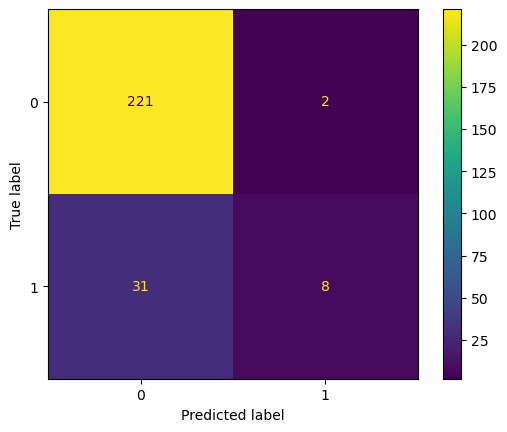

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test_top10, y_pred), display_labels=classification_pipeline_test.classes_).plot()

## Not many people match in general, so it does not do a good job at identifying who matches. Balance weights and try again.

In [21]:
classification_pipeline_balanced = Pipeline([('transformer', transformer_top10),
                                    ('RF_model', RandomForestClassifier(max_depth=23, min_impurity_decrease=0.0008982385551574712, min_samples_leaf=9, class_weight='balanced'))])

In [22]:
scores3 = cross_val_score(classification_pipeline_balanced, X_train_top10, y_train_top10, cv=5)
print(scores3.mean(), '\t', scores3.std())

#goes down to 80% when balanced weights

0.8028218979279206 	 0.020687581596993704


In [23]:
#fit and predict
classification_pipeline_balanced.fit(X_train_top10, y_train_top10)
classification_pipeline_balanced.predict(X_test_top10)

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [24]:
#find accuracy
y_pred3 = classification_pipeline_balanced.predict(X_test_top10)
sum(y_pred3 == y_test_top10) / len(y_test_top10)

#83% accurate on testing data with balanced weights

0.8282442748091603

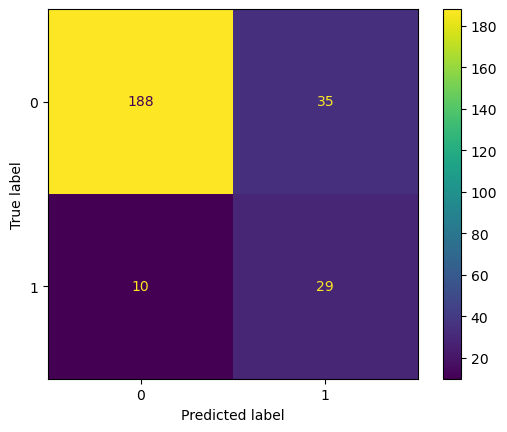

In [25]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test_top10, y_pred3), display_labels=classification_pipeline_balanced.classes_).plot()

## Balanced weights does predict matching better, but it also misses non matches more than before

# Introduce PCA to the mix

### PCA in 2 dimensions

/var/folders/s3/xv1zbv396w155jxwc4kwhqlh0000gn/T/ipykernel_25346/1722726533.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent_r', 2))


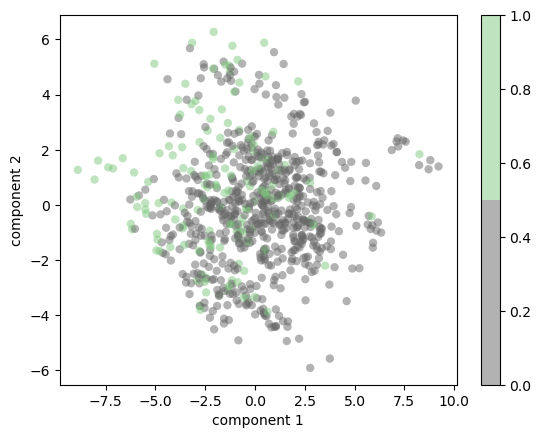

In [52]:
pca2 = Pipeline([('transformer', transformer),
                         ('pca', PCA(2))]) #project to 2 dimensions
projected = pca2.fit_transform(X_train2)

import matplotlib.pyplot as plt

plt.scatter(projected[:, 0], projected[:, 1],
            c=y_train2, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent_r', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### Using only 2 dimensions does not describe our data well

### See how many dimensions are needed for a good fit

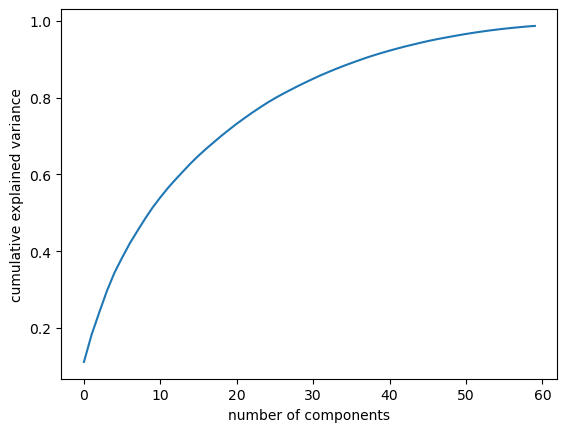

In [26]:
from sklearn.decomposition import PCA

pca = Pipeline([('transformer', transformer),
                         ('pca', PCA(60))]) #first start with most of the features

pca.fit(X_train2) #pca can't handle nan entries either

pca['pca']

plt.plot(np.cumsum(pca['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Need about 40 components to explain 90% of the data

## Combine: Use PCA with Random Forest

### (Using all data, not just top 10 features)

In [49]:
pca_pipeline = Pipeline([('transformer', transformer),
                         ('pca', PCA(40)),
                         ('RF', RandomForestClassifier(class_weight='balanced'))]) #use RF since performed best before

pca_pipeline.fit(X_train2, y_train2)

y_pred4 = pca_pipeline.predict(X_test2)

sum(y_pred4 == y_test2)/len(y_test2)

#85% accurate with PCA and RF

0.8473282442748091

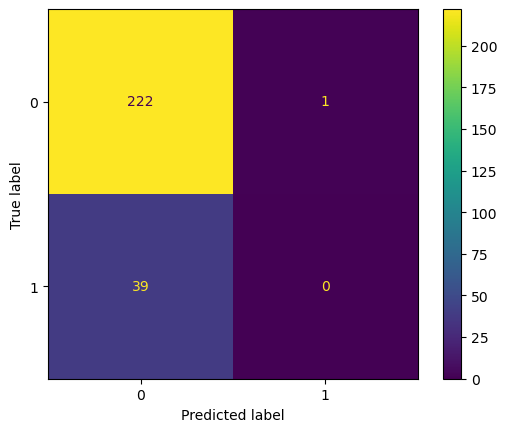

In [51]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test2, y_pred4), display_labels=pca_pipeline.classes_).plot()

### Still have the same problem, even with PCA and balanced weights. Christy to the rescue!